In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import time

# 2D

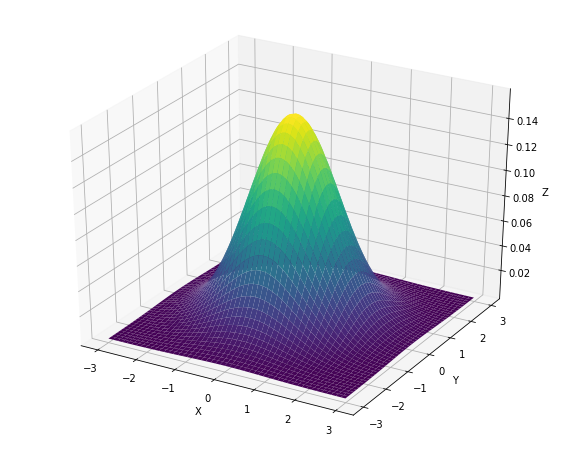

In [61]:
# true value
true_mean = np.array([0.0, 0.0]) 
true_covariance = np.array([[1.0, 0.0], [0.0, 1.0]]) 

x_total, y_total = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x_total, y_total))

# probability density
rv = multivariate_normal(true_mean, true_covariance)
z = rv.pdf(pos)

# 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection= '3d')
ax.plot_surface(x_total, y_total, z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
fig.savefig('multivariate_gaussian_distribution.png')

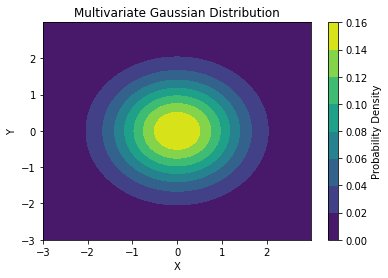

In [62]:
# 2D
plt.contourf(x_total, y_total, z, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Multivariate Gaussian Distribution')
plt.colorbar(label='Probability Density')
plt.show()

# now we have known the true MGD, and what we want to do is to get the data - data points in conditional MGD. 

# the following two Contrastive Divergences' conditional mean and covariance are the same as the total data, so we do not need to change it.

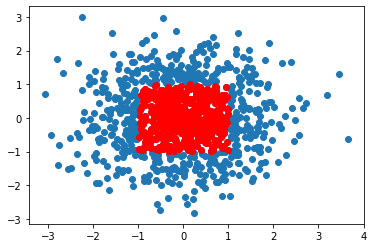

In [63]:
total_data = np.random.multivariate_normal(true_mean, true_covariance, 1000)

x_min, x_max = -1, 1
y_min, y_max = -1, 1

x = []
y = []
data = []
for i in range(len(total_data)):
    if total_data[:,0][i] >= x_min and total_data[:,0][i] <= x_max:       
        if (total_data[:,1][i] >= y_min and total_data[:,1][i] <= y_max):
            x.append(total_data[i][0])
            y.append(total_data[i][1])
            data.append([total_data[i][0],total_data[i][1]])

plt.scatter(total_data[:,0], total_data[:,1],label = 'Multivariate Gaussian')
plt.scatter(x, y, color = 'red')
plt.savefig('MGD_con1.png')

In [64]:
# define the truncated MGD log likelihood
def log_likelihood(x, mean, cov):
    # have the log likelihood of MGD * indicated function
    if x[0] >= lower_bound[0] and x[1] >= lower_bound[1] and x[0] <= upper_bound[0] and x[1] <= upper_bound[1]:
        return multivariate_normal.logpdf(x, mean, cov)
    else:
        e = 1e-20
        return multivariate_normal.logpdf(x, mean, cov) + np.log(e)

# log accpetance rate
def log_acceptance_probability(candidate_x, current_x, mean, covariance):
    return log_likelihood(candidate_x, mean, covariance) - log_likelihood(current_x, mean, covariance)

# proposal distribution
def proposal_distribution(current_x, proposal_std, cov):
    x = np.random.multivariate_normal(np.zeros(len(current_x)), cov)
    re = current_x + proposal_std * x
    return re

def partial_mean(x, mean, cov):
    inv_covariance = np.linalg.inv(cov)
    pa_mean = inv_covariance @ (x - mean)
    return  pa_mean

def partial_cov(x, mean, cov):
    inv = np.linalg.inv(cov)
    diff = x - mean
    return -0.5 * (inv - inv @ np.outer(diff, diff) @ inv)

In [65]:
def MH(num , train_data, pro_std, mean, cov):
    # initialize
    current_x = train_data 
    samples_x = []

    for _ in range(num):
        
        # produce candidate by proposal distribution
        candidate_x = proposal_distribution(current_x, pro_std, cov)
        a_r = log_acceptance_probability(candidate_x, current_x, mean, cov)
        
        if np.log(np.random.uniform(0,1)) < a_r:
            current_x = candidate_x
        
        samples_x.append(current_x)
    
    return samples_x

In [76]:
def MH_1step(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    sigmai=[]
    sigmai1 = []
    initial_state = sample[0]
    num_sample = len(sample)

    time1 = time.time()
    l2 = []
    
    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])

        X = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        MSE = ((np.array(X) - np.array(sample)) ** 2).mean()
        l2.append(MSE)

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i
        
    time2 = time.time()
    time_cost = time2 - time1
    return ni, mui, mui1, sigmai, sigmai1,time_cost, l2

In [78]:
def MH_persistant(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    sigmai=[]
    sigmai1 = []
    initial_state = sample[0]
    num_sample = len(sample)

    time1 = time.time()
    l2 = []
    
    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])

        X = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        initial_state = X[-1]
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        MSE = ((np.array(X) - np.array(sample)) ** 2).mean()
        l2.append(MSE)

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i

    time2 = time.time()
    time_cost = time2 - time1
    return ni, mui, mui1, sigmai, sigmai1, time_cost, l2

In [79]:
def MH_3step(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    sigmai=[]
    sigmai1 = []
    initial_state = sample[0]
    num_sample = len(sample)
    
    time1 = time.time()
    l2 = []

    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])

        X1 = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        X2 = MH(num_sample, X1[-1], pro, mean_1step, covariance_1tep)
        X = MH(num_sample, X2[-1], pro, mean_1step, covariance_1tep)
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        MSE = ((np.array(X) - np.array(sample)) ** 2).mean()
        l2.append(MSE)

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i
        
    time2 = time.time()
    time_cost = time2 - time1
    return ni, mui, mui1, sigmai, sigmai1, time_cost, l2

x_min, x_max = -1, 1; y_min, y_max = -1, 1 and the mean of MGD is 0

In [77]:
# 1 step with mean [-1.5,1.5]
eta = 0.1
mean_0= np.array([-1.5,1.5])
covariance_matrix_0 = np.array([[0.5,0.0], [0.0,0.5]])
lower_bound = np.array([-1,-1])
upper_bound = np.array([1,1])
# proposal Standard deviation
proposal_std = 0.5
iteration = 5000

A = MH_1step(eta, mean_0, covariance_matrix_0, proposal_std, data, iteration)

cov1: 0.7936736034287623
cov2: 0.8973954998423537


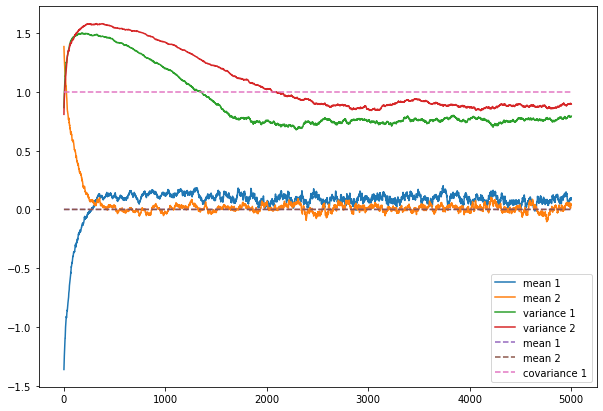

In [80]:
x = []
y = []
x22 = []
for i in range(iteration):
    x1 = true_mean[0]
    x2 = true_mean[1]
    y1 = true_covariance[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)

plt.figure(figsize=(10,7))
plt.plot(A[0],A[1],label = 'mean 1')
plt.plot(A[0],A[2],label = 'mean 2')
plt.plot(A[0],A[3],label = 'variance 1')
plt.plot(A[0],A[4],label = 'variance 2')
plt.plot(A[0],x, linestyle = '--', label = 'mean 1')
plt.plot(A[0],x22, linestyle = '--', label = 'mean 2')
plt.plot(A[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = A[3][-1]
last_covvalue2 = A[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()
plt.savefig('1step_CD_con_2D.png')

In [81]:
# 3 step with mean 
eta = 0.1
mean_0= np.array([-0.5,0.5])
covariance_matrix_0 = np.array([[1.5,0.0], [0.0,1.5]])
lower_bound = np.array([-1,-1])
upper_bound = np.array([1,1])
# proposal Standard deviation
proposal_std = 0.5
iteration = 5000

A = MH_3step(eta, mean_0, covariance_matrix_0, proposal_std, data, iteration)

cov1: 0.759766401068782
cov2: 0.8594497826021009


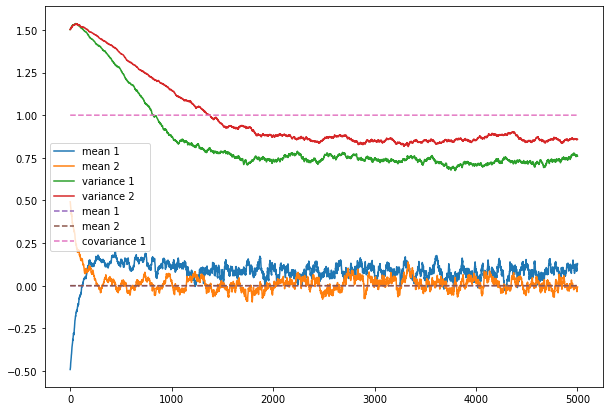

In [82]:
# set the true data
x = []
y = []
x22 = []
for i in range(iteration):
    x1 = true_mean[0]
    x2 = true_mean[1]
    y1 = true_covariance[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)
    
# the graph of 1D CD
plt.figure(figsize=(10,7))
plt.plot(A[0],A[1],label = 'mean 1')
plt.plot(A[0],A[2],label = 'mean 2')
plt.plot(A[0],A[3],label = 'variance 1')
plt.plot(A[0],A[4],label = 'variance 2')
plt.plot(A[0],x, linestyle = '--', label = 'mean 1')
plt.plot(A[0],x22, linestyle = '--', label = 'mean 2')
plt.plot(A[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = A[3][-1]
last_covvalue2 = A[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()
plt.savefig('3step_CD_con_2D.png')

In [89]:
# persistent with mean
eta = 0.1
mean_0= np.array([-1.5,1.5])
covariance_matrix_0 = np.array([[1.5,0.0], [0.0,1.5]])
lower_bound = np.array([-1,-1])
upper_bound = np.array([1,1])
# proposal Standard deviation
proposal_std = 0.5
iteration = 5000

P = MH_persistant(eta, mean_0, covariance_matrix_0, proposal_std, data, iteration)

cov1: 0.7370873011154828
cov2: 0.872761927115504


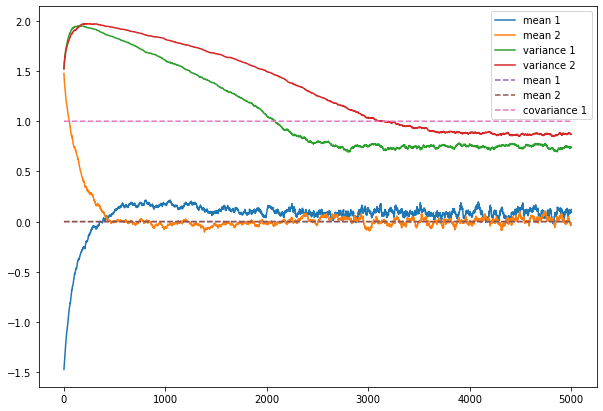

In [90]:
# persistant CD
x = []
y = []
x22 = []
for i in range(iteration):
    x1 = true_mean[0]
    x2 = true_mean[1]
    y1 = true_covariance[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)

plt.figure(figsize=(10,7))
plt.plot(P[0],P[1],label = 'mean 1')
plt.plot(P[0],P[2],label = 'mean 2')
plt.plot(P[0],P[3],label = 'variance 1')
plt.plot(P[0],P[4],label = 'variance 2')
plt.plot(P[0],x, linestyle = '--', label = 'mean 1')
plt.plot(P[0],x22, linestyle = '--', label = 'mean 2')
plt.plot(P[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = P[3][-1]
last_covvalue2 = P[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()
plt.savefig('persistant_CD_con_2D.png')

# part II change (enlarge the data domain)

x_min, x_max = -2, 2; y_min, y_max = -2, 2 and the mean of MGD is 0

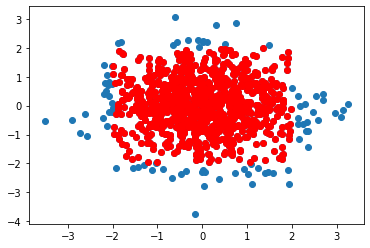

In [30]:
total_data_2 = np.random.multivariate_normal(true_mean, true_covariance, 1000)

x_min, x_max = -2, 2
y_min, y_max = -2, 2

x = []
y = []
data_2 = []
for i in range(len(total_data_2)):
    if total_data_2[:,0][i] >= x_min and total_data_2[:,0][i] <= x_max:       
        if (total_data_2[:,1][i] >= y_min and total_data_2[:,1][i] <= y_max):
            x.append(total_data_2[i][0])
            y.append(total_data_2[i][1])
            data_2.append([total_data_2[i][0],total_data_2[i][1]])

plt.scatter(total_data_2[:,0], total_data_2[:,1],label = 'Multivariate Gaussian')
plt.scatter(x, y, color = 'red')

In [31]:
# 1 step with mean [-2.5,2.5]
eta = 0.1
mean_0= np.array([-2.5,2.5])
covariance_matrix_0 = np.array([[0.5,0.0], [0.0,0.5]])
# proposal Standard deviation
proposal_std = 0.5
lower_bound = np.array([-2,-2])
upper_bound = np.array([2,2])
iteration = 2000

A = MH_1step(eta, mean_0, covariance_matrix_0, proposal_std, data_2, iteration)

[-2.17333032  2.18108261]
[-2.14607856  2.15424835]
[-2.12461173  2.13326838]
[-2.10415474  2.1102486 ]
[-2.08063673  2.08467499]
[-2.06301567  2.05932584]
[-2.04303702  2.03631715]
[-2.02246398  2.01829682]
[-1.99601258  2.00343869]
[-1.97294029  1.98077695]
[-1.95388439  1.96151643]
[-1.93445875  1.94315405]
[-1.91366648  1.92467758]
[-1.89658503  1.90715658]
[-1.87504034  1.88710545]
[-1.85513462  1.86771364]
[-1.83535521  1.84671116]
[-1.81328035  1.82996903]
[-1.7926154   1.80761568]
[-1.78417592  1.79046617]
[-1.77052002  1.77301587]
[-1.75476841  1.75679542]
[-1.73659874  1.73841658]
[-1.72126794  1.71751496]
[-1.70698509  1.70186933]
[-1.68797849  1.6893242 ]
[-1.67533566  1.67191115]
[-1.66185442  1.65497931]
[-1.64752711  1.63870636]
[-1.63080482  1.62899927]
[-1.61285805  1.60883948]
[-1.59484033  1.59919806]
[-1.58406064  1.58992986]
[-1.56754526  1.58112972]
[-1.55125031  1.56693224]
[-1.53865484  1.55079833]
[-1.52572843  1.54350327]
[-1.50637687  1.53358061]
[-1.48876136

cov1: 1.0090653839244543
cov2: 1.0090653839244543


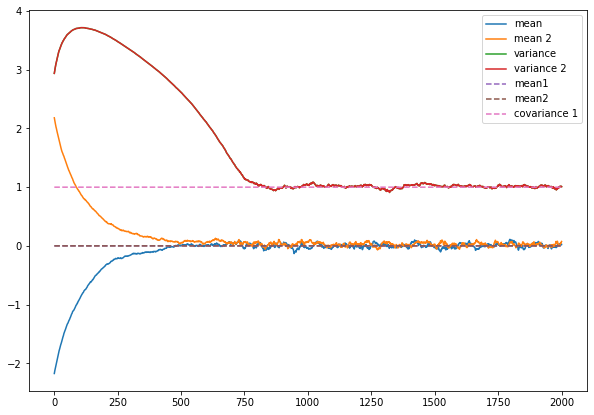

In [32]:
x = []
y = []
x22 = []
for i in range(iteration):
    x1 = true_mean[0]
    x2 = true_mean[1]
    y1 = true_covariance[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)

plt.figure(figsize=(10,7))
plt.plot(A[0],A[1],label = 'mean')
plt.plot(A[0],A[2],label = 'mean 2')
plt.plot(A[0],A[3],label = 'variance')
plt.plot(A[0],A[4],label = 'variance 2')
plt.plot(A[0],x, linestyle = '--', label = 'mean1')
plt.plot(A[0],x22, linestyle = '--', label = 'mean2')
plt.plot(A[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = A[3][-1]
last_covvalue2 = A[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()

In [33]:
# persistant CD with mean [-2.5,2.5]
eta = 0.1
mean_0= np.array([-2.5,2.5])
covariance_matrix_0 = np.array([[0.5,0.0], [0.0,0.5]])

# proposal Standard deviation
proposal_std = 0.5
iteration = 2000

P = MH_persistant(eta, mean_0, covariance_matrix_0, proposal_std, data_2, iteration)

[-2.17896401  2.18943242]
[-2.15261529  2.16572035]
[-2.12246095  2.13872275]
[-2.09363486  2.11598686]
[-2.06608638  2.09439915]
[-2.040505    2.07346895]
[-2.01576631  2.04822541]
[-1.99887386  2.0294202 ]
[-1.97176912  2.00622443]
[-1.95509559  1.98434328]
[-1.93690685  1.96550562]
[-1.91448906  1.95149051]
[-1.89281886  1.9287644 ]
[-1.86873017  1.916497  ]
[-1.84528047  1.89350226]
[-1.82385122  1.87291343]
[-1.80699146  1.85680434]
[-1.7897358   1.84223534]
[-1.77598909  1.82991159]
[-1.75554485  1.81442073]
[-1.7381911   1.79737753]
[-1.72128707  1.78168288]
[-1.70575653  1.76653861]
[-1.68603627  1.74454335]
[-1.67036777  1.72936996]
[-1.65320443  1.70974663]
[-1.63924993  1.69456715]
[-1.62132894  1.67822963]
[-1.60333666  1.65607917]
[-1.58965977  1.64219629]
[-1.57602317  1.63448882]
[-1.56010172  1.61936803]
[-1.5468182   1.60234349]
[-1.52982409  1.58780734]
[-1.51205291  1.57864141]
[-1.50011519  1.5697558 ]
[-1.4877927   1.55264468]
[-1.47489732  1.54135359]
[-1.4619066 

cov1: 1.0416846004144167
cov2: 1.0416846004144167


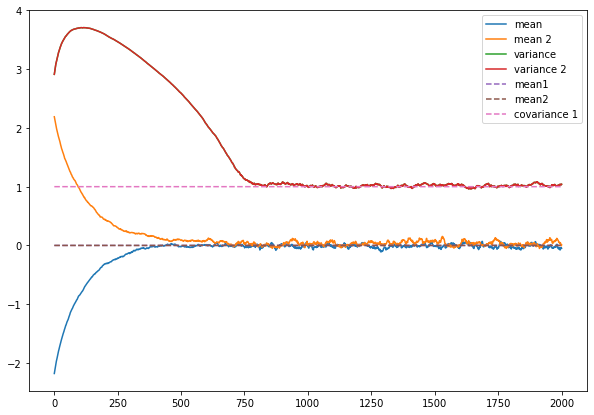

In [34]:
x = []
y = []
x22 = []
for i in range(iteration):
    x1 = true_mean[0]
    x2 = true_mean[1]
    y1 = true_covariance[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)

plt.figure(figsize=(10,7))
plt.plot(P[0],P[1],label = 'mean')
plt.plot(P[0],P[2],label = 'mean 2')
plt.plot(P[0],P[3],label = 'variance')
plt.plot(P[0],P[4],label = 'variance 2')
plt.plot(P[0],x, linestyle = '--', label = 'mean1')
plt.plot(P[0],x22, linestyle = '--', label = 'mean2')
plt.plot(P[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = P[3][-1]
last_covvalue2 = P[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()

In [37]:
print(f'1 step 300, 600, 900 is {A[1][200]}, {A[1][400]}, {A[1][600]}')
print(f'persistant 300, 600, 900 is {P[1][200]}, {P[1][400]}, {P[1][600]}')

1 step 300, 600, 900 is -0.3394349277734458, -0.09835347754009993, 0.012947682565305367
persistant 300, 600, 900 is -0.31487613343343823, -0.024105640951587053, 0.012284963628978839


# another try( we use this example in the thesis)

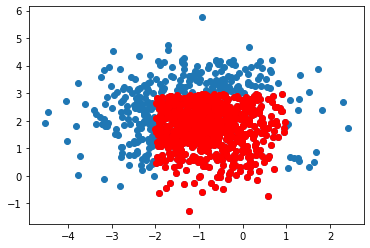

In [85]:
# true value[-1.2]
true_mean_1 = np.array([-1, 2]) 
true_covariance_1 = np.array([[1.0, 0.0], [0.0, 1.0]]) 

total_data_6 = np.random.multivariate_normal(true_mean_1, true_covariance_1, 1000)

x_min, x_max = -2, 1
y_min, y_max = -2, 3

x = []
y = []
data_6 = []
for i in range(len(total_data_6)):
    if total_data_6[:,0][i] >= x_min and total_data_6[:,0][i] <= x_max:       
        if (total_data_6[:,1][i] >= y_min and total_data_6[:,1][i] <= y_max):
            x.append(total_data_6[i][0])
            y.append(total_data_6[i][1])
            data_dash = np.array([total_data_6[i][0],total_data_6[i][1]])
            data_6.append(data_dash)

plt.scatter(total_data_6[:,0], total_data_6[:,1],label = 'Multivariate Gaussian')
plt.scatter(x, y, color = 'red')
plt.savefig('MGD_con_2D_shifted.png')

In [86]:
# define the truncated MGD log likelihood
def log_likelihood(x, mean, cov):
    # have the log likelihood of MGD * indicated function
    if x[0] >= lower_bound[0] and x[1] >= lower_bound[1] and x[0] <= upper_bound[0] and x[1] <= upper_bound[1]:
        return multivariate_normal.logpdf(x, mean, cov)
    else:
        e = 1e-5
        return multivariate_normal.logpdf(x, mean, cov) + np.log(e)

In [87]:
eta = 0.1
mean_0= np.array([0.5,-0.5])
covariance_matrix_0 = np.array([[3.0,0.0], [0.0,3.0]])
# proposal Standard deviation
lower_bound = np.array([-2,-2])
upper_bound = np.array([1,3])
proposal_std = 0.1
iteration = 5000

B = MH_1step(eta, mean_0, covariance_matrix_0, proposal_std, data_6 , iteration)

cov1: 1.173781752141735
cov2: 0.7126737391641565


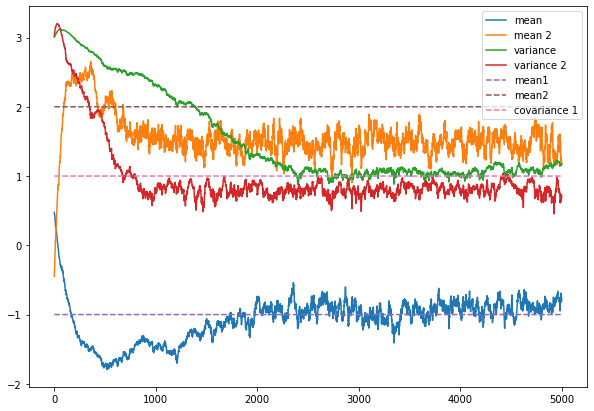

In [88]:
x = []
y = []
x22 = []
for i in range(iteration):
    x1 = true_mean_1[0]
    x2 = true_mean_1[1]
    y1 = true_covariance_1[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)

plt.figure(figsize=(10,7))
plt.plot(B[0],B[1],label = 'mean')
plt.plot(B[0],B[2],label = 'mean 2')
plt.plot(B[0],B[3],label = 'variance')
plt.plot(B[0],B[4],label = 'variance 2')
plt.plot(B[0],x, linestyle = '--', label = 'mean1')
plt.plot(B[0],x22, linestyle = '--', label = 'mean2')
plt.plot(B[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = B[3][-1]
last_covvalue2 = B[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()
plt.savefig('1step_CD_con_2D_shifted.png')

# pentagram( we use this in the thesis)

In [4]:
# pentagram creation
def judge(x, y, poly):
    num = len(poly)
    j = num - 1
    c = False
    for i in range(num):
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < (poly[j][0] - poly[i][0]) * (y - poly[i][1]) / (poly[j][1] - poly[i][1]) + poly[i][0]):
            c = not c
        j = i
    return c

def create_pentagram(center, size):
    # Calculate outer vertices
    points = []
    for i in range(5):
        theta = np.deg2rad(i * 72 - 90)
        points.append((center[0] + size * np.cos(theta), center[1] + size * np.sin(theta)))
    
    # Calculate inner vertices
    inner_points = []
    for i in range(5):
        next_i = (i + 2) % 5
        inner_points.append(((points[i][0] + points[next_i][0]) / 2, (points[i][1] + points[next_i][1]) / 2))
    
    # Combine into pentagram shape
    pentagram = []
    for i in range(5):
        pentagram.append(points[i])
        pentagram.append(inner_points[i])
    
    return pentagram


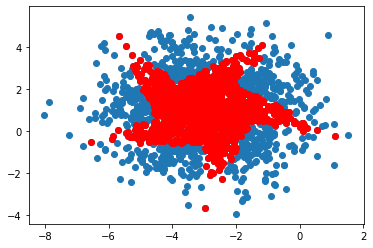

In [5]:
# true value
true_mean_1 = np.array([-3, 1]) 
true_covariance_1 = np.array([[2.0, 0.0], [0.0, 2.0]]) 

total_data_7 = np.random.multivariate_normal(true_mean_1, true_covariance_1, 2000)

# coordinates of the pentagram
center = (-3, 1)
size = 5
pentagram = create_pentagram(center, size)
poly = pentagram

x = []
y = []
data_7 = []
for o in range(len(total_data_7)):
    inside = judge(total_data_7[o][0], total_data_7[o][1], poly)
    if inside == True:
            x.append(total_data_7[o][0])
            y.append(total_data_7[o][1])
            data_dash = np.array([total_data_7[o][0],total_data_7[o][1]])
            data_7.append(data_dash)

plt.scatter(total_data_7[:,0], total_data_7[:,1],label = 'Multivariate Gaussian')
plt.scatter(x, y, color = 'red')
plt.savefig('MGD_con_2D_pentagram.png')

the plot plot all the covariance

In [93]:
# define the truncated MGD log likelihood
def log_likelihood(x, mean, cov):
    # have the log likelihood of MGD * indicated function
    if judge(x[0],x[1],pentagram) == True:
        return multivariate_normal.logpdf(x, mean, cov)
    else:
        e = 1e-20
        return np.log(e)

In [94]:
def MH(num , train_data, pro_std, mean, cov):
    # initialize
    current_x = train_data 
    samples_x = []

    for _ in range(num):
        
        # produce candidate by proposal distribution
        candidate_x = proposal_distribution(current_x, pro_std, cov)
        a_r = log_acceptance_probability(candidate_x, current_x, mean, cov)
        
        if np.log(np.random.uniform(0,1)) < a_r:
            current_x = candidate_x
        
        samples_x.append(current_x)
    
    return samples_x

In [95]:
# MH 1 step print covariance
def MH_1step(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    sigmai=[]
    sigmai1 = []
    initial_state = sample[0]
    num_sample = len(sample)
    
    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])

        X = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i

    return ni, mui, mui1, sigmai, sigmai1

In [96]:
# persistant step plot all the covariance
def MH_persistant(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    sigmai=[]
    sigmai1 = []
    initial_state = sample[0]
    num_sample = len(sample)
    
    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])

        X = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        initial_state = X[-1]
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i
        print(covariance_matrix_i[0][0])
    return ni, mui, mui1, sigmai, sigmai1

In [98]:
# 3 step plot all the covariance
def MH_3step(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    sigmai=[]
    sigmai1 = []
    initial_state = sample[0]
    num_sample = len(sample)
    
    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])

        X_1 = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        X_2 = MH(num_sample, X_1[-1], pro, mean_1step, covariance_1tep)
        X = MH(num_sample, X_2[-1], pro, mean_1step, covariance_1tep)
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i
        print(covariance_matrix_i[0][0])
    return ni, mui, mui1, sigmai, sigmai1

In [97]:
# 1 step with mean [-2,0] with covariance 4
eta = 0.1
mean_0= np.array([-2.0,0.0])
covariance_matrix_0 = np.array([[4.0,0.0], [0.0,4.0]])
proposal_std = 0.1
iteration = 5000

B = MH_1step(eta, mean_0, covariance_matrix_0, proposal_std, data_7 , iteration)

cov1: 2.527330358396816
cov2: 1.499424176447579


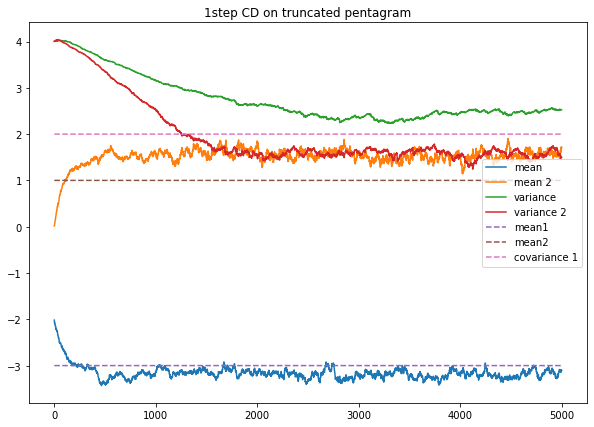

In [99]:
x = []
y = []
x22 = []
for i in range(iteration):
    x1 = true_mean_1[0]
    x2 = true_mean_1[1]
    y1 = true_covariance_1[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)

plt.figure(figsize=(10,7))
plt.plot(B[0],B[1],label = 'mean')
plt.plot(B[0],B[2],label = 'mean 2')
plt.plot(B[0],B[3],label = 'variance')
plt.plot(B[0],B[4],label = 'variance 2')
plt.plot(B[0],x, linestyle = '--', label = 'mean1')
plt.plot(B[0],x22, linestyle = '--', label = 'mean2')
plt.plot(B[0],y, linestyle = '--', label = 'covariance 1')
plt.title('1step CD on truncated pentagram')
last_covvalue1 = B[3][-1]
last_covvalue2 = B[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()
plt.savefig('1step_CD_con_2D_pentagram.png')

In [19]:
# persistant CD with mean [-2.0,0.0] and proposal std 0.1 with covariance 4
eta = 0.1
mean_0= np.array([-2.0,0.0])
covariance_matrix_0 = np.array([[4.0,0.0], [0.0,4.0]])
proposal_std = 0.1
iteration = 2000

B_per = MH_persistant(eta, mean_0, covariance_matrix_0, proposal_std, data_7 , iteration)

3.9978220502276076
3.9966306573510204
4.000810992847139
4.00352388016877
4.005099326188399
4.00308962012058
4.005619817810337
4.0109095551521206
4.012063226062511
4.016193757759104
4.018928663332805
4.019666491916778
4.023574598844485
4.024811437604502
4.026376415771993
4.03084138518842
4.032489381046509
4.0290008095343675
4.032857902253604
4.019506600413538
4.023930028631139
4.018642133113016
4.018427474635332
4.01910461734532
4.016584714790997
4.019512963458472
4.022090795557892
4.020595691365451
4.018023251486625
4.021288062219382
4.022879998553194
4.022056409497376
4.0212971801080455
4.022303981405423
4.024199090109757
4.02362709883357
4.024618949292132
4.023591072180188
4.021805462389312
4.015171367287004
4.015166466901529
4.016589372638533
4.0173760500729445
4.016586158194092
4.019926875667013
4.021571284579708
4.019130621927493
4.015228475799314
4.008109991481367
4.009030776366239
4.007478237074906
4.006377570918291
4.006859819092035
4.004702114353905
4.005462555569394
4.0071377

cov1: 2.1022868601253664
cov2: 2.1022868601253664


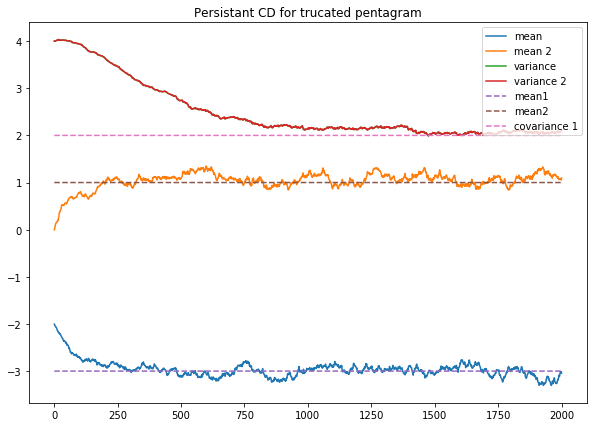

In [22]:
x = []
y = []
x22 = []
for i in range(iteration):
    x1 = true_mean_1[0]
    x2 = true_mean_1[1]
    y1 = true_covariance_1[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)

plt.figure(figsize=(10,7))
plt.title('Persistant CD for trucated pentagram')
plt.plot(B_per[0],B_per[1],label = 'mean')
plt.plot(B_per[0],B_per[2],label = 'mean 2')
plt.plot(B_per[0],B_per[3],label = 'variance')
plt.plot(B_per[0],B_per[4],label = 'variance 2')
plt.plot(B_per[0],x, linestyle = '--', label = 'mean1')
plt.plot(B_per[0],x22, linestyle = '--', label = 'mean2')
plt.plot(B_per[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = B_per[3][-1]
last_covvalue2 = B_per[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()

# different type of pentagram(small pentagram) keep the data number equal for ED

# compare the size

In [1]:
import random
import seaborn as sns
import torch
import numpy as np
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import Normal
import time 

In [107]:
# define the model for the Multivariate Gaussian distribution
class MultivariateGaussian(nn.Module):
    def __init__(self, mean: float, cov: float):
        super(MultivariateGaussian, self).__init__()
        self.mean = nn.Parameter(torch.tensor([mean]).squeeze(), requires_grad=True)
        self.cov = nn.Parameter(torch.tensor([cov]).squeeze(), requires_grad=True)
        self.dim = self.mean.shape[-1]

    def forward(self, x):
        cov_matrix = self.cov.view(self.dim, self.dim)
        cov_matrix = cov_matrix @ cov_matrix.T + torch.eye(self.dim) * 1e-6
        self.inv_cov = torch.inverse(cov_matrix)
        self.det_cov = torch.det(cov_matrix)
        self.norm_const = 1.0 / torch.sqrt((2 * np.pi) ** self.dim * self.det_cov)
        x = x.float()
        diff = x - self.mean
        exponent = -0.5 * torch.sum(diff @ self.inv_cov * diff, dim=1)
        return - torch.log(self.norm_const * torch.exp(exponent))

    def sample(self, num_samples: int):
        # ensure the covariance matrix is positive definite
        cov = self.cov
        cov = cov @ cov.T
        samples = self.mean + torch.randn(num_samples, self.dim) @ torch.linalg.cholesky(cov)
        return samples

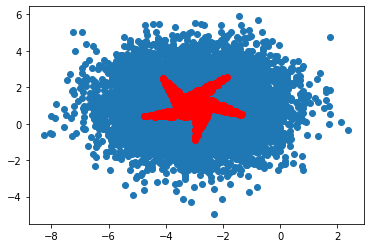

In [120]:
# true value
true_mean_1 = np.array([-3, 1]) 
true_covariance_1 = np.array([[2.0, 0.0], [0.0, 2.0]]) 

total_data_7 = np.random.multivariate_normal(true_mean_1, true_covariance_1, 10000)

# coordinates of the pentagram
center = (-3, 1)
size = 2
pentagram = create_pentagram(center, size)
poly = pentagram

x = []
y = []
data_7 = []
for o in range(len(total_data_7)):
    inside = judge(total_data_7[o][0], total_data_7[o][1], poly)
    if inside == True:
            x.append(total_data_7[o][0])
            y.append(total_data_7[o][1])
            data_dash = np.array([total_data_7[o][0],total_data_7[o][1]])
            data_7.append(data_dash)
            if len(data_7) == 1000:
                break

plt.scatter(total_data_7[:,0], total_data_7[:,1],label = 'Multivariate Gaussian')
plt.scatter(x, y, color = 'red')
plt.savefig('MGD_con_2D_size2_pentagram.png')

In [109]:
# define loss function converge to the energy discrepancy 
def ED(E_theta, samples, M = 4, t =1, w=1):
    device = samples.device

    si_i = np.sqrt(t) * torch.randn_like(samples).to(device)
    si_ij = np.sqrt(t) * torch.randn(samples.size(0), M, *samples.shape[1:]).to(device)

    sum_part = samples.unsqueeze(1) + si_i.unsqueeze(1) + si_ij
    
    # compute the part of loss part
    E_1 = E_theta(samples).view(samples.size(0), -1)
    E_2 = E_theta(sum_part.view(-1, *samples.shape[1:])).view(samples.size(0), -1)

    # compute the loss in the sum part
    loss_i = E_1 - E_2
    
    if w != 0:
        loss_i = torch.cat([loss_i, np.log(w) * torch.ones_like(loss_i[:, :1])], dim=-1)
    
    # take the logsumexp step to compute the loss
    loss = loss_i.logsumexp(dim=-1).mean()
    return loss

# train the loop
def train(model, data, epochs=1000, learning_rate=0.1):
    loss1 = []
    mu1 = []
    mu2 = []
    sigma1 = []
    sigma2 = []
    step = []
    
    time1 = time.time()
    l2 = []

    # gradient descent
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = ED(E_theta=model, samples=data, w=w_stable)
        
        mu_1 = model.mean[0].item()
        cov_1 = model.cov[0][0].item()

        loss1.append(loss.item())
        mu1.append(mu_1)
        mu2.append(model.mean[1].item())
        sigma1.append(cov_1)
        sigma2.append(model.cov[1][1].item())

        sample_train = model.sample(data.size(0)).detach().numpy()
        true_sample = np.random.multivariate_normal(true_mean_1, true_covariance_1, 1000)
        MSE = ((sample_train - observed_data_tensor2D.detach().numpy()) ** 2).mean()

        l2.append(MSE)

        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}, mu1 = {mu_1}, sigma1 = {cov_1}")
        step.append(epoch)

    time2 = time.time()

    return loss1, mu1, mu2, sigma1, step, time2-time1, l2,sigma2

In [110]:
# define the target model for the multivariate Gaussian distribution
observed_data_tensor2D = torch.tensor(np.array(data_7))

# initilaize the model
mu_init2D = [-4.0, 3.0]
sigma_init2D = [[3.0, 0.0], [0.0, 3.0]]

w_stable = 10.0
model2D = MultivariateGaussian(mu_init2D, sigma_init2D)

In [111]:
# train the model
A = train(model2D, observed_data_tensor2D)

Epoch 0: Loss = 2.5951900482177734, mu1 = -4.0, sigma1 = 3.0
Epoch 100: Loss = 2.4463295936584473, mu1 = -2.9988083839416504, sigma1 = 0.7375567555427551
Epoch 200: Loss = 2.4351272583007812, mu1 = -2.9892354011535645, sigma1 = 0.8038938045501709
Epoch 300: Loss = 2.448058605194092, mu1 = -3.0169763565063477, sigma1 = 0.7756165266036987
Epoch 400: Loss = 2.4415228366851807, mu1 = -2.9914495944976807, sigma1 = 0.7545462846755981
Epoch 500: Loss = 2.4299943447113037, mu1 = -2.947737455368042, sigma1 = 0.7077881097793579
Epoch 600: Loss = 2.439274549484253, mu1 = -3.0617754459381104, sigma1 = 0.7312488555908203
Epoch 700: Loss = 2.437471866607666, mu1 = -3.0103917121887207, sigma1 = 0.7591046690940857
Epoch 800: Loss = 2.4406752586364746, mu1 = -3.0142054557800293, sigma1 = 0.756693422794342
Epoch 900: Loss = 2.4410014152526855, mu1 = -2.9960508346557617, sigma1 = 0.7787634134292603


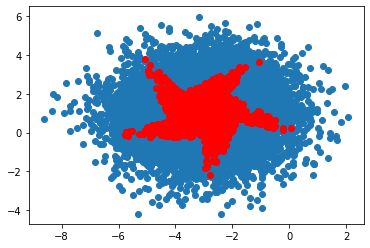

In [112]:
# true value
true_mean_1 = np.array([-3, 1]) 
true_covariance_1 = np.array([[2.0, 0.0], [0.0, 2.0]]) 

# coordinates of the pentagram
center = (-3, 1)
size = 4
pentagram = create_pentagram(center, size)
poly = pentagram

x = []
y = []
data_7 = []
for o in range(len(total_data_7)):
    inside = judge(total_data_7[o][0], total_data_7[o][1], poly)
    if inside == True:
            x.append(total_data_7[o][0])
            y.append(total_data_7[o][1])
            data_dash = np.array([total_data_7[o][0],total_data_7[o][1]])
            data_7.append(data_dash)
            if len(data_7) == 1000:
                break

plt.scatter(total_data_7[:,0], total_data_7[:,1],label = 'Multivariate Gaussian')
plt.scatter(x, y, color = 'red')
plt.savefig('MGD_con_2D_size4_pentagram.png')

In [113]:
observed_data_tensor2D = torch.tensor(np.array(data_7))

In [114]:
# train the model
w_stable = 10.0
model2D = MultivariateGaussian(mu_init2D, sigma_init2D)

B = train(model2D, observed_data_tensor2D)

Epoch 0: Loss = 2.60048770904541, mu1 = -4.0, sigma1 = 3.0
Epoch 100: Loss = 2.51776123046875, mu1 = -3.0194172859191895, sigma1 = 1.1769561767578125
Epoch 200: Loss = 2.520350694656372, mu1 = -3.079697847366333, sigma1 = 1.194495677947998
Epoch 300: Loss = 2.5176000595092773, mu1 = -3.012934446334839, sigma1 = 1.1311272382736206
Epoch 400: Loss = 2.522287607192993, mu1 = -3.0704572200775146, sigma1 = 1.2014356851577759
Epoch 500: Loss = 2.5066440105438232, mu1 = -2.9718077182769775, sigma1 = 1.1872795820236206
Epoch 600: Loss = 2.5177958011627197, mu1 = -3.054666519165039, sigma1 = 1.2132388353347778
Epoch 700: Loss = 2.5206010341644287, mu1 = -3.016390800476074, sigma1 = 1.2178616523742676
Epoch 800: Loss = 2.5222885608673096, mu1 = -3.0621564388275146, sigma1 = 1.2001899480819702
Epoch 900: Loss = 2.52534818649292, mu1 = -3.0176756381988525, sigma1 = 1.1942532062530518


1000

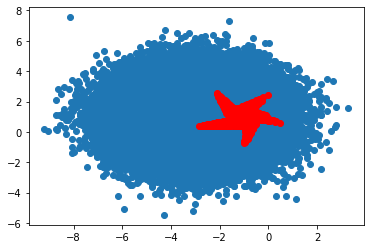

In [123]:
# true value
true_mean_1 = np.array([-3, 1]) 
true_covariance_1 = np.array([[2.0, 0.0], [0.0, 2.0]]) 

total_data_7 = np.random.multivariate_normal(true_mean_1, true_covariance_1, 100000)

# coordinates of the pentagram
center = (-1, 1)
size = 2
pentagram = create_pentagram(center, size)
poly = pentagram

x = []
y = []
data_7 = []
for o in range(len(total_data_7)):
    inside = judge(total_data_7[o][0], total_data_7[o][1], poly)
    if inside == True:
            x.append(total_data_7[o][0])
            y.append(total_data_7[o][1])
            data_dash = np.array([total_data_7[o][0],total_data_7[o][1]])
            data_7.append(data_dash)
            if len(data_7) == 1000:
                break

plt.scatter(total_data_7[:,0], total_data_7[:,1],label = 'Multivariate Gaussian')
plt.scatter(x, y, color = 'red')
plt.savefig('MGD_con_2D_size2shifted_pentagram.png')
len(data_7)

In [124]:
observed_data_tensor2D = torch.tensor(np.array(data_7))

# train the model
w_stable = 10.0
model2D = MultivariateGaussian(mu_init2D, sigma_init2D)

C = train(model2D, observed_data_tensor2D)

Epoch 0: Loss = 2.614352226257324, mu1 = -4.0, sigma1 = 3.0
Epoch 100: Loss = 2.4321377277374268, mu1 = -1.263100504875183, sigma1 = 0.7555488348007202
Epoch 200: Loss = 2.437276840209961, mu1 = -1.3966690301895142, sigma1 = 0.6573585271835327
Epoch 300: Loss = 2.42755126953125, mu1 = -1.361068844795227, sigma1 = 0.6768338084220886
Epoch 400: Loss = 2.438899278640747, mu1 = -1.347637414932251, sigma1 = 0.6873302459716797
Epoch 500: Loss = 2.4347105026245117, mu1 = -1.3445355892181396, sigma1 = 0.6594089269638062
Epoch 600: Loss = 2.4328439235687256, mu1 = -1.340375542640686, sigma1 = 0.6642842888832092
Epoch 700: Loss = 2.4331860542297363, mu1 = -1.3246097564697266, sigma1 = 0.699467122554779
Epoch 800: Loss = 2.433079242706299, mu1 = -1.3487759828567505, sigma1 = 0.6735224723815918
Epoch 900: Loss = 2.434561014175415, mu1 = -1.2957772016525269, sigma1 = 0.7149853110313416


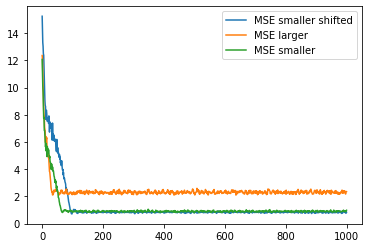

In [135]:
plt.plot(C[-2], label = 'MSE smaller shifted')
plt.plot(B[-2], label = 'MSE larger')
plt.plot(A[-2], label = 'MSE smaller')
plt.legend()
plt.savefig('MSE_con_2D_size_pentagram_compare.png')

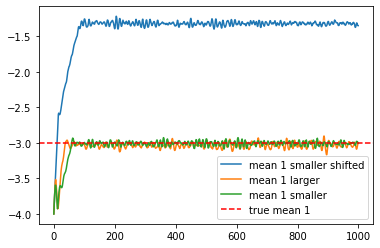

In [136]:
plt.plot(C[1], label = 'mean 1 smaller shifted')
plt.plot(B[1], label = 'mean 1 larger')
plt.plot(A[1], label = 'mean 1 smaller')
plt.axhline(y=true_mean_1[0], color='r', linestyle='--', label = 'true mean 1')
plt.legend()
plt.savefig('mean1_con_2D_size_pentagram_compare.png')

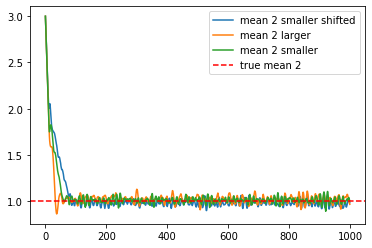

In [137]:
plt.plot(C[2], label = 'mean 2 smaller shifted')
plt.plot(B[2], label = 'mean 2 larger')
plt.plot(A[2], label = 'mean 2 smaller')
plt.axhline(y=true_mean_1[1], color='r', linestyle='--', label = 'true mean 2')
plt.legend()
plt.savefig('mean2_con_2D_size_pentagram_compare.png')

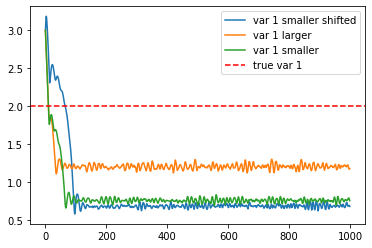

In [140]:
plt.plot(C[3], label = 'var 1 smaller shifted')
plt.plot(B[3], label = 'var 1 larger')
plt.plot(A[3], label = 'var 1 smaller')
plt.axhline(y=true_covariance_1[0][0], color='r', linestyle='--', label = 'true var 1')
plt.legend()
plt.savefig('var1_con_2D_size_pentagram_compare.png')

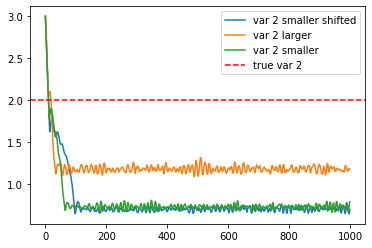

In [141]:
plt.plot(C[7], label = 'var 2 smaller shifted')
plt.plot(B[7], label = 'var 2 larger')
plt.plot(A[7], label = 'var 2 smaller')
plt.axhline(y=true_covariance_1[1][1], color='r', linestyle='--', label = 'true var 2')
plt.legend()
plt.savefig('var2_con_2D_size_pentagram_compare.png')